In [172]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
from ASLDataset import ASLDataset
import torch.optim as optim
import time
from torchsummary import summary
import torchvision.models as models

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(device)

cuda


The baseline model from scratch in 3.1.

In [173]:
class ConvBlock(nn.Module):

    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.relu(self.bn(self.conv(x)))

class BaselineModel(nn.Module):
    def __init__(self, input_feature):
        super().__init__()
        
        self.layer0 = nn.Sequential(
            nn.Conv2d(input_feature, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        
        self.layer1 = nn.Sequential(
            ConvBlock(64, 128, kernel_size=3, stride=2),
            ConvBlock(128, 128, kernel_size=3, stride=2),
            ConvBlock(128, 256, kernel_size=3, stride=2),
            ConvBlock(256, 256, kernel_size=3, stride=2),
        )
        self.gpool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(256, 29)
        
        

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.gpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)

        return x


The Resnet style network from scratch.

In [174]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.skip = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=2),
            nn.BatchNorm2d(out_channels)
        )

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        x1 = self.skip(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(x + x1)
        return x
    
class ResNetStyle(nn.Module):
    def __init__(self, input_feature):
        super().__init__()
        self.layer0 = nn.Sequential(
            nn.Conv2d(input_feature, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.layer1 = nn.Sequential(
            ResBlock(64, 128),
            ResBlock(128, 256),
        )

        self.gpool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = torch.nn.Linear(256, 29)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.gpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)

        return x
    

The Inception style network from scratch.

In [175]:
class InceptionBlock(nn.Module):

    def __init__(self, in_channels, ch_1x1, ch_3x3_1, ch_3x3_2, ch_5x5_1, ch_5x5_2, ch_pool):
        super().__init__()

        self.p_1x1 = ConvBlock(in_channels, ch_1x1, kernel_size=1)

        self.p_3x3_1 = ConvBlock(in_channels, ch_3x3_1, kernel_size=1)
        self.p_3x3_2 = ConvBlock(ch_3x3_1, ch_3x3_2, kernel_size=3, padding=1)

        self.p_5x5_1 = ConvBlock(in_channels, ch_5x5_1, kernel_size=1)
        self.p_5x5_2 = ConvBlock(ch_5x5_1, ch_5x5_2, kernel_size=5, padding=2)

        self.p_pool_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p_pool_2 = ConvBlock(in_channels, ch_pool, kernel_size=1)

    def forward(self, x):
        x1 = self.p_1x1(x)

        x2 = self.p_3x3_1(x)
        x2 = self.p_3x3_2(x2)

        x3 = self.p_5x5_1(x)
        x3 = self.p_5x5_2(x3)

        x4 = self.p_pool_1(x)
        x4 = self.p_pool_2(x4)

        x = torch.cat([x1, x2, x3, x4], 1)
        return x


class InceptionStyle(nn.Module):

    def __init__(self, in_channels):
        super().__init__()

        self.layer0 = nn.Sequential(
            ConvBlock(in_channels, 64, kernel_size=7, stride=2, padding=3),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            ConvBlock(64, 192, kernel_size=3, stride=1, padding=1),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )

        self.layer1 = nn.Sequential(
            InceptionBlock(192, 64, 96, 128, 16, 32, 32),
            InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        )

        self.gpool = torch.nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(480, 29)

    def forward(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.gpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [176]:
resNetStyle = ResNetStyle(3).to(device)
criterion_r = nn.CrossEntropyLoss()
optimizer_r = optim.Adam(resNetStyle.parameters(), lr=0.01, weight_decay=0.001)
scheduler_r = torch.optim.lr_scheduler.MultiStepLR(optimizer_r, milestones=[4,10,15], gamma=0.1)

summary(resNetStyle,(3, 200, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,472
         MaxPool2d-2           [-1, 64, 50, 50]               0
       BatchNorm2d-3           [-1, 64, 50, 50]             128
              ReLU-4           [-1, 64, 50, 50]               0
            Conv2d-5          [-1, 128, 25, 25]           8,320
       BatchNorm2d-6          [-1, 128, 25, 25]             256
            Conv2d-7          [-1, 128, 25, 25]          73,856
       BatchNorm2d-8          [-1, 128, 25, 25]             256
            Conv2d-9          [-1, 128, 25, 25]         147,584
      BatchNorm2d-10          [-1, 128, 25, 25]             256
         ResBlock-11          [-1, 128, 25, 25]               0
           Conv2d-12          [-1, 256, 13, 13]          33,024
      BatchNorm2d-13          [-1, 256, 13, 13]             512
           Conv2d-14          [-1, 256,

In [177]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# define the train and test methods
def train(model, data_loader, criterion, optimizer, scheduler):
    
    model.train()
    running_loss = 0.0

    for i, data in enumerate(data_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    
    scheduler.step()
    
    
    return running_loss / len(data_loader)


def test(model, dataloader):
    correct = 0
    total = 0
    model.eval()
    y_pre = []
    y = []
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            images, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #
            y_pre.extend(predicted.cpu().tolist())
            y.extend(labels.cpu().tolist())
    # cm
    cm = confusion_matrix(y, y_pre)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    
    return correct/total

In [178]:
no_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
rotation = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomRotation((-20, 20)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)
grayscale = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Grayscale(),
     transforms.Normalize(0.5,0.5)]
)

trainset = ASLDataset('train',transform=no_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = ASLDataset('test',transform=no_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

Train the baseline model without preprocessing.

In [179]:
# baselineModel = BaselineModel(3).to(device)
# criterion_b = nn.CrossEntropyLoss()
# optimizer_b = optim.Adam(baselineModel.parameters(), lr=0.01, weight_decay=0.001)
# scheduler_b = torch.optim.lr_scheduler.MultiStepLR(optimizer_b, milestones=[4,10,15], gamma=0.1)


# summary(baselineModel,(3, 200, 200))

# for epoch in range(20):  # loop over the dataset multiple times

#     start_time = time.time()
#     train_loss = train(baselineModel, trainloader, criterion_b, optimizer_b, scheduler_b)
#     test_acc = test(baselineModel, testloader)
        
#     print(f'Epoch: {epoch+1}, time used: {time.time()-start_time:.2f}s, training loss: {train_loss:.6f}, test accuracy:{test_acc:.6f}')

In [180]:
# torch.save(baselineModel.state_dict(), f'./trained_models/baselineModel_model.pth')

The baseline model using grayscale preprocessing.

In [181]:
# trainset = ASLDataset('train',transform=grayscale)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
#                                           shuffle=True, num_workers=2)

# testset = ASLDataset('test',transform=grayscale)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=2)

# baselineModel = BaselineModel(1).to(device)
# criterion_b = nn.CrossEntropyLoss()
# optimizer_b = optim.Adam(baselineModel.parameters(), lr=0.01, weight_decay=0.001)
# scheduler_b = torch.optim.lr_scheduler.MultiStepLR(optimizer_b, milestones=[4,10,15], gamma=0.1)


# summary(baselineModel,(1, 200, 200))

# for epoch in range(20):  # loop over the dataset multiple times

#     start_time = time.time()
#     train_loss = train(baselineModel, trainloader, criterion_b, optimizer_b, scheduler_b)
#     test_acc = test(baselineModel, testloader)
        
#     print(f'Epoch: {epoch+1}, time used: {time.time()-start_time:.2f}s, training loss: {train_loss:.6f}, test accuracy:{test_acc:.6f}')

The baseline model using rotation preprocessing.

In [182]:
# trainset = ASLDataset('train',transform=rotation)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
#                                           shuffle=True, num_workers=2)

# testset = ASLDataset('test',transform=no_transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=2)

# baselineModel = BaselineModel(3).to(device)
# criterion_b = nn.CrossEntropyLoss()
# optimizer_b = optim.Adam(baselineModel.parameters(), lr=0.01, weight_decay=0.001)
# scheduler_b = torch.optim.lr_scheduler.MultiStepLR(optimizer_b, milestones=[4,10,15], gamma=0.1)


# summary(baselineModel,(3, 200, 200))

# for epoch in range(20):  # loop over the dataset multiple times

#     start_time = time.time()
#     train_loss = train(baselineModel, trainloader, criterion_b, optimizer_b, scheduler_b)
#     test_acc = test(baselineModel, testloader)
        
#     print(f'Epoch: {epoch+1}, time used: {time.time()-start_time:.2f}s, training loss: {train_loss:.6f}, test accuracy:{test_acc:.6f}')

Resnet style CNN without preprocessing.

In [183]:
# trainset = ASLDataset('train',transform=no_transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
#                                           shuffle=True, num_workers=1)

# testset = ASLDataset('test',transform=no_transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=1)

# resNetStyle = ResNetStyle(3).to(device)
# criterion_r = nn.CrossEntropyLoss()
# optimizer_r = optim.Adam(resNetStyle.parameters(), lr=0.01, weight_decay=0.001)
# scheduler_r = torch.optim.lr_scheduler.MultiStepLR(optimizer_r, milestones=[4,10,15], gamma=0.1)


# summary(resNetStyle,(3, 200, 200))

# for epoch in range(20):  # loop over the dataset multiple times

#     start_time = time.time()
#     train_loss = train(resNetStyle, trainloader, criterion_r, optimizer_r, scheduler_r)
#     test_acc = test(resNetStyle, testloader)
        
#     print(f'Epoch: {epoch+1}, time used: {time.time()-start_time:.2f}s, training loss: {train_loss:.6f}, test accuracy:{test_acc:.6f}')

Resnet style CNN without grayscale images.

In [184]:

# trainset = ASLDataset('train',transform=grayscale)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
#                                           shuffle=True, num_workers=1)

# testset = ASLDataset('test',transform=grayscale)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=1)

resNetStyle = ResNetStyle(1).to(device)
# criterion_r = nn.CrossEntropyLoss()
# optimizer_r = optim.Adam(resNetStyle.parameters(), lr=0.01, weight_decay=0.001)
# scheduler_r = torch.optim.lr_scheduler.MultiStepLR(optimizer_r, milestones=[4,10,15], gamma=0.1)


summary(resNetStyle,(1, 200, 200))

# for epoch in range(20):  # loop over the dataset multiple times

#     start_time = time.time()
#     train_loss = train(resNetStyle, trainloader, criterion_r, optimizer_r, scheduler_r)
#     test_acc = test(resNetStyle, testloader)
        
#     print(f'Epoch: {epoch+1}, time used: {time.time()-start_time:.2f}s, training loss: {train_loss:.6f}, test accuracy:{test_acc:.6f}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           3,200
         MaxPool2d-2           [-1, 64, 50, 50]               0
       BatchNorm2d-3           [-1, 64, 50, 50]             128
              ReLU-4           [-1, 64, 50, 50]               0
            Conv2d-5          [-1, 128, 25, 25]           8,320
       BatchNorm2d-6          [-1, 128, 25, 25]             256
            Conv2d-7          [-1, 128, 25, 25]          73,856
       BatchNorm2d-8          [-1, 128, 25, 25]             256
            Conv2d-9          [-1, 128, 25, 25]         147,584
      BatchNorm2d-10          [-1, 128, 25, 25]             256
         ResBlock-11          [-1, 128, 25, 25]               0
           Conv2d-12          [-1, 256, 13, 13]          33,024
      BatchNorm2d-13          [-1, 256, 13, 13]             512
           Conv2d-14          [-1, 256,

Inception style CNN without preprocessing.

In [185]:
# trainset = ASLDataset('train',transform=no_transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
#                                           shuffle=True, num_workers=2)

# testset = ASLDataset('test',transform=no_transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=2)
inceptionStyle = InceptionStyle(3).to(device)
# criterion_i = nn.CrossEntropyLoss()
# optimizer_i = optim.Adam(inceptionStyle.parameters(), lr=0.01, weight_decay=0.001)
# scheduler_i = torch.optim.lr_scheduler.MultiStepLR(optimizer_i, milestones=[4,10,15], gamma=0.1)


summary(inceptionStyle,(3, 200, 200))

# for epoch in range(20):  # loop over the dataset multiple times

#     start_time = time.time()
#     train_loss = train(inceptionStyle, trainloader, criterion_i, optimizer_i, scheduler_i)
#     test_acc = test(inceptionStyle, testloader)
        
#     print(f'Epoch: {epoch+1}, time used: {time.time()-start_time:.2f}s, training loss: {train_loss:.6f}, test accuracy:{test_acc:.6f}')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 100, 100]           9,472
       BatchNorm2d-2         [-1, 64, 100, 100]             128
              ReLU-3         [-1, 64, 100, 100]               0
         ConvBlock-4         [-1, 64, 100, 100]               0
         MaxPool2d-5           [-1, 64, 50, 50]               0
            Conv2d-6          [-1, 192, 50, 50]         110,784
       BatchNorm2d-7          [-1, 192, 50, 50]             384
              ReLU-8          [-1, 192, 50, 50]               0
         ConvBlock-9          [-1, 192, 50, 50]               0
        MaxPool2d-10          [-1, 192, 25, 25]               0
           Conv2d-11           [-1, 64, 25, 25]          12,352
      BatchNorm2d-12           [-1, 64, 25, 25]             128
             ReLU-13           [-1, 64, 25, 25]               0
        ConvBlock-14           [-1, 64,

Inception style CNN with grayscale images.

In [186]:
# trainset = ASLDataset('train',transform=grayscale)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
#                                           shuffle=True, num_workers=2)

# testset = ASLDataset('test',transform=grayscale)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=2)


# inceptionStyle = InceptionStyle(1).to(device)
# criterion_i = nn.CrossEntropyLoss()
# optimizer_i = optim.Adam(inceptionStyle.parameters(), lr=0.01, weight_decay=0.001)
# scheduler_i = torch.optim.lr_scheduler.MultiStepLR(optimizer_i, milestones=[4,10,15], gamma=0.1)


# summary(inceptionStyle,(1, 200, 200))

# for epoch in range(20):  # loop over the dataset multiple times

#     start_time = time.time()
#     train_loss = train(inceptionStyle, trainloader, criterion_i, optimizer_i, scheduler_i)
#     test_acc = test(inceptionStyle, testloader)
        
#     print(f'Epoch: {epoch+1}, time used: {time.time()-start_time:.2f}s, training loss: {train_loss:.6f}, test accuracy:{test_acc:.6f}')

Transfer learning using the Resnet18.

In [187]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
    # transforms.Gray(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
)

In [188]:
# import mlflow.pytorch
# from mlflow import MlflowClient

# resnet = models.resnet18(pretrained=True)
# for param in resnet.parameters():
#     param.requires_grad = False
# for param in resnet.layer4.parameters():
#     param.requires_grad = True

# num_ftrs = resnet.fc.in_features
# resnet.fc = nn.Linear(num_ftrs, 29)
# resnet.to(device)

# # data set
# trainset = ASLDataset('train',transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
#                                           shuffle=True, num_workers=2)

# testset = ASLDataset('test',transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=2)

# # summary(resnet, (3,224,224))

# criterion_t_r = nn.CrossEntropyLoss()
# optimizer_t_r = optim.Adam(filter(lambda p: p.requires_grad, resnet.parameters()), lr=0.01, weight_decay=0.001)
# scheduler_t_r = torch.optim.lr_scheduler.MultiStepLR(optimizer_t_r, milestones=[4,10,15], gamma=0.1)

# mlflow.set_tracking_uri("sqlite:///641.db")
# mlflow.set_registry_uri("sqlite:///641.db")
# client = MlflowClient(tracking_uri="sqlite:///641.db")

# run = client.create_run(experiment_id='0')

# mlflow.pytorch.autolog()

# # training
# # loop over the dataset multiple times
# for epoch in range(20):  
    
#     start_time = time.time()
#     train_loss = train(resnet, trainloader, criterion_t_r, optimizer_t_r, scheduler_t_r)
#     test_acc = test(resnet, testloader)

#     client.log_metric(run.info.run_id, "test_acc", test_acc, step=epoch)
#     client.log_metric(run.info.run_id, "train_loss", train_loss, step=epoch)
    
#     print(f'Epoch: {epoch+1}, time used: {time.time()-start_time:.2f}s, training loss: {train_loss:.6f}, test accuracy:{test_acc:.6f}')

# # log
# mlflow.pytorch.log_model(resnet, "model_output")
# # convert to scripted model and log the model
# scripted_pytorch_resnet = torch.jit.script(resnet)
# mlflow.pytorch.log_model(scripted_pytorch_resnet, "scripted_model")
# # save
# model_uri = f'runs:/{run.info.run_id}/model_output'
# mlflow.register_model(model_uri, "ResNet")

2022/12/09 17:20:15 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.


time used: 0.74s, test accuracy:0.889776


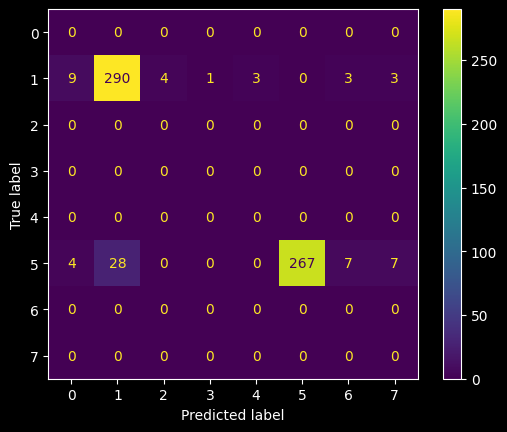

In [189]:
import mlflow.pytorch
from mlflow import MlflowClient
from ASLDataset import ASLDataset

mlflow.set_tracking_uri("sqlite:///641.db")
mlflow.set_registry_uri("sqlite:///641.db")
client = MlflowClient(tracking_uri="sqlite:///641.db")
run = client.create_run(experiment_id='1')

mlflow.pytorch.autolog()

testset = ASLDataset('test',transform=transform, local_classes=['E', 'S'])
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)
    
resnet = torch.load('./model_output/data/model.pth')

start_time = time.time()
# train_loss = train(resnet, trainloader, criterion_t_r, optimizer_t_r, scheduler_t_r)
test_acc = test(resnet, testloader)

client.log_metric(run.info.run_id, "test_acc", test_acc)

print(f'time used: {time.time()-start_time:.2f}s, test accuracy:{test_acc:.6f}')

2022/12/09 17:20:35 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.


time used: 0.72s, test accuracy:0.833866


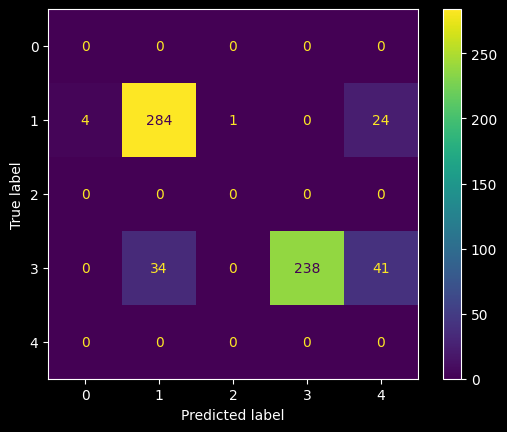

In [199]:
import mlflow.pytorch
from mlflow import MlflowClient
from ASLDataset import ASLDataset

mlflow.set_tracking_uri("sqlite:///641.db")
mlflow.set_registry_uri("sqlite:///641.db")
client = MlflowClient(tracking_uri="sqlite:///641.db")
run = client.create_run(experiment_id='1')

mlflow.pytorch.autolog()

testset = ASLDataset('test',transform=transform, local_classes=['E', 'S'], scource=False) # 
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)
    
resnet = models.resnet18(pretrained=False)
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, 29)
resnet.load_state_dict(torch.load('./trained_models/resnet_raw.pth'))
resnet.eval()
resnet.to(device)

start_time = time.time()
# train_loss = train(resnet, trainloader, criterion_t_r, optimizer_t_r, scheduler_t_r)
test_acc = test(resnet, testloader)

client.log_metric(run.info.run_id, "test_acc", test_acc)

print(f'time used: {time.time()-start_time:.2f}s, test accuracy:{test_acc:.6f}')

Transfer learning using the InceptionV3.

In [191]:
# inception = models.inception_v3(pretrained=True)

# for param in inception.parameters():
#     param.requires_grad = False
# for param in inception.Mixed_7c.parameters():
#     param.requires_grad = True
    
# num_ftrs = inception.fc.in_features
# inception.fc = nn.Linear(num_ftrs, 29)
# inception.to(device)
# print(inception)
# summary(inception, (3,299,299))

In [192]:
# def train_inc(model, data_loader, criterion, optimizer, scheduler):
    
#     model.train()
#     running_loss = 0.0

#     for i, data in enumerate(data_loader, 0):
#         inputs, labels = data[0].to(device), data[1].to(device)

#         optimizer.zero_grad()
#         outputs, aux_output = model(inputs)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item()
    
#     scheduler.step()
    
    
#     return running_loss / len(data_loader)


# def test_inc(model, dataloader):
#     correct = 0
#     total = 0
#     model.eval()
#     # since we're not training, we don't need to calculate the gradients for our outputs
#     with torch.no_grad():
#         for data in dataloader:
#             images, labels = data[0].to(device), data[1].to(device)
#             # calculate outputs by running images through the network
#             outputs, aux_output = model(images)
#             # the class with the highest energy is what we choose as prediction
#             _, predicted = torch.max(outputs.data, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
    
#     return correct/total

In [193]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Resize((299,299)),
#      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
# )

# trainset = ASLDataset('train',transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
#                                           shuffle=True, num_workers=2)

# testset = ASLDataset('test',transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=2)

# criterion_t_i = nn.CrossEntropyLoss()
# optimizer_t_i = optim.Adam(filter(lambda p: p.requires_grad, inception.parameters()), lr=0.01, weight_decay=0.001)
# scheduler_t_i = torch.optim.lr_scheduler.MultiStepLR(optimizer_t_i, milestones=[4,10,15], gamma=0.1)


# for epoch in range(20):  # loop over the dataset multiple times
    
#     start_time = time.time()
#     train_loss = train_inc(inception, trainloader, criterion_t_i, optimizer_t_i, scheduler_t_i)
#     test_acc = test(inception, testloader)
    
#     print(f'Epoch: {epoch+1}, time used: {time.time()-start_time:.2f}s, training loss: {train_loss:.6f}, test accuracy:{test_acc:.6f}')

In [194]:
# torch.save(inception.state_dict(), f'./trained_models/inception_raw.pth')

Transfer learning using the efficientnet.

In [195]:
# efficientnet = models.efficientnet_b0(pretrained=True)

# for param in efficientnet.parameters():
#     param.requires_grad = False
# for param in efficientnet.features[8].parameters():
#     param.requires_grad = True
    
# num_ftrs = efficientnet.classifier[1].in_features
# efficientnet.classifier[1] = nn.Linear(num_ftrs, 29)
# efficientnet.to(device)
# print(efficientnet)
# summary(efficientnet, (3,224,224))

In [196]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Resize((224,224)),
#      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
# )

# trainset = ASLDataset('train',transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
#                                           shuffle=True, num_workers=2)

# testset = ASLDataset('test',transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=2)

# criterion_t_e = nn.CrossEntropyLoss()
# optimizer_t_e = optim.Adam(filter(lambda p: p.requires_grad, efficientnet.parameters()), lr=0.01, weight_decay=0.001)
# scheduler_t_e = torch.optim.lr_scheduler.MultiStepLR(optimizer_t_e, milestones=[4,10,15], gamma=0.1)


# for epoch in range(20):  # loop over the dataset multiple times
    
#     start_time = time.time()
#     train_loss = train(efficientnet, trainloader, criterion_t_e, optimizer_t_e, scheduler_t_e)
#     test_acc = test(efficientnet, testloader)
    
#     print(f'Epoch: {epoch+1}, time used: {time.time()-start_time:.2f}s, training loss: {train_loss:.6f}, test accuracy:{test_acc:.6f}')

Transfer learning using the mobilenet_v3_small.

In [197]:
# mobilenet_v3_small = models.mobilenet_v3_small(pretrained=False)
# mobilenet_v3_small.load_state_dict(torch.load('./trained_models/mobilenet_v3_small-047dcff4.pth'))

# for param in mobilenet_v3_small.features.parameters():
#     param.requires_grad = False
# for param in mobilenet_v3_small.features[12].parameters():
#     param.requires_grad = True
    
# num_ftrs = mobilenet_v3_small.classifier[3].in_features
# mobilenet_v3_small.classifier[3] = nn.Linear(num_ftrs, 29)
# mobilenet_v3_small.to(device)
# print(mobilenet_v3_small)
# summary(mobilenet_v3_small, (3,224,224))


In [198]:
# transform = transforms.Compose(
#     [transforms.ToTensor(),
#      transforms.Resize((224,224)),
#      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
# )

# trainset = ASLDataset('train',transform=transform)
# trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
#                                           shuffle=True, num_workers=2)

# testset = ASLDataset('test',transform=transform)
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,
#                                          shuffle=False, num_workers=2)

# criterion_t_m = nn.CrossEntropyLoss()
# optimizer_t_m = optim.Adam(filter(lambda p: p.requires_grad, mobilenet_v3_small.parameters()), lr=0.01, weight_decay=0.001)
# scheduler_t_m = torch.optim.lr_scheduler.MultiStepLR(optimizer_t_m, milestones=[4,10,15], gamma=0.1)


# for epoch in range(20):  # loop over the dataset multiple times
    
#     start_time = time.time()
#     train_loss = train(mobilenet_v3_small, trainloader, criterion_t_m, optimizer_t_m, scheduler_t_m)
#     test_acc = test(mobilenet_v3_small, testloader)
    
#     print(f'Epoch: {epoch+1}, time used: {time.time()-start_time:.2f}s, training loss: {train_loss:.6f}, test accuracy:{test_acc:.6f}')